<a href="https://colab.research.google.com/github/josematez/DeepLearning_SkinCancer/blob/main/DenseNet_Test_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepdish
!pip install numpy==1.15.4

     |████████████████████████████████| 13.9MB 250kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.15.4 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.1 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd
#from tqdm import tqdm
#from glob import glob
#import seaborn as sns
#import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

#import itertools

#import cv2
#from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ISIC_Dataset')

Mounted at /content/drive


In [3]:
data = dd.io.load('ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [4]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [5]:
X = np.zeros((10015, 75, 100, 3))

for i in range(10015):
  X[i,:,:,:] = X_raw[i]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)

In [7]:
X_train = (X_train / np.max(X_train))
X_test = (X_test / np.max(X_test))
X_val = (X_val / np.max(X_val))

In [8]:
Y_train = to_categorical(Y_train, num_classes = 7)
Y_test = to_categorical(Y_test, num_classes = 7)
Y_val = to_categorical(Y_val, num_classes = 7)

In [9]:
# DATA AUGMENTATION
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=60,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [10]:
# DENSENET201 MODEL
input_shape = X_train[0].shape
n_classes = len(Y_train[0])

densenet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet.trainable = False

model = tf.keras.models.Sequential()
model.add(densenet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))    
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

74842112/74836368 [==============================] - 1s 0us/step


In [11]:
epocas = 30
bs = 20
lr = 0.001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Define checkpoint to save best Phase 1 weights
best_weights_ph1 = "ph1_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint]

In [12]:
historico = model.fit(datagen.flow(X_train, Y_train, batch_size = bs), epochs = epocas, batch_size = bs, validation_data = (X_val, Y_val), callbacks = callbacks)
#historico = model.fit(X_train, Y_train, epochs = epocas, batch_size = bs, validation_split = 0.1, callbacks = callbacks)

Epoch 1/30
406/406 [==============================] - ETA: 0s - loss: 1.4479 - accuracy: 0.5870
Epoch 00001: val_loss improved from inf to 0.77182, saving model to ph1_weights.hdf5
406/406 [==============================] - 28s 68ms/step - loss: 1.4479 - accuracy: 0.5870 - val_loss: 0.7718 - val_accuracy: 0.7494
Epoch 2/30
406/406 [==============================] - ETA: 0s - loss: 0.9592 - accuracy: 0.6918
Epoch 00002: val_loss improved from 0.77182 to 0.71731, saving model to ph1_weights.hdf5
406/406 [==============================] - 23s 58ms/step - loss: 0.9592 - accuracy: 0.6918 - val_loss: 0.7173 - val_accuracy: 0.7472
Epoch 3/30
406/406 [==============================] - ETA: 0s - loss: 0.8789 - accuracy: 0.7000
Epoch 00003: val_loss improved from 0.71731 to 0.71423, saving model to ph1_weights.hdf5
406/406 [==============================] - 24s 58ms/step - loss: 0.8789 - accuracy: 0.7000 - val_loss: 0.7142 - val_accuracy: 0.7472
Epoch 4/30
406/406 [==============================

In [13]:
model.load_weights(best_weights_ph1)

In [14]:
metricas = model.evaluate(X_test, Y_test)

32/32 [==============================] - 2s 57ms/step - loss: 0.6124 - accuracy: 0.7784


In [15]:
densenet.trainable = True

epocas = 30
bs = 20
lr = 0.0001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Define checkpoint to save best Phase 1 weights
best_weights_ph2 = "ph2_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint]

In [16]:
historico = model.fit(datagen.flow(X_train, Y_train, batch_size = bs), epochs = epocas, batch_size = bs, validation_data = (X_val, Y_val), callbacks = callbacks)

Epoch 1/30
406/406 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.7283
Epoch 00001: val_loss improved from inf to 0.65528, saving model to ph2_weights.hdf5
406/406 [==============================] - 48s 118ms/step - loss: 0.7550 - accuracy: 0.7283 - val_loss: 0.6553 - val_accuracy: 0.7583
Epoch 2/30
406/406 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.7616
Epoch 00002: val_loss improved from 0.65528 to 0.59197, saving model to ph2_weights.hdf5
406/406 [==============================] - 43s 106ms/step - loss: 0.6621 - accuracy: 0.7616 - val_loss: 0.5920 - val_accuracy: 0.7916
Epoch 3/30
406/406 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.7768
Epoch 00003: val_loss did not improve from 0.59197
406/406 [==============================] - 38s 93ms/step - loss: 0.6195 - accuracy: 0.7768 - val_loss: 0.6259 - val_accuracy: 0.7683
Epoch 4/30
406/406 [==============================] - ETA: 0s - loss: 0.6004 - accurac

In [17]:
model.load_weights(best_weights_ph2)

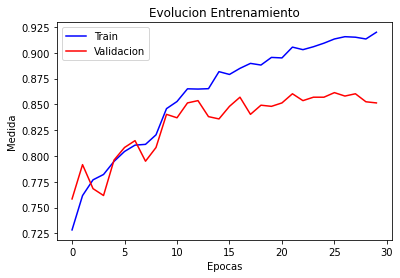

In [18]:
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

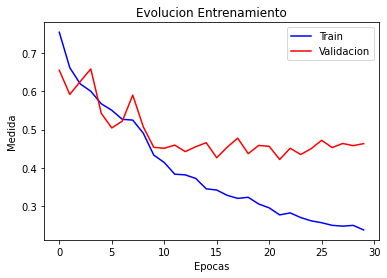

In [19]:
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [20]:
metricas = model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 33ms/step - loss: 0.3882 - accuracy: 0.8693


In [24]:
from sklearn import metrics

Y_pred = model.predict(X_test)
print('Confusion Matrix')
print(metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

Confusion Matrix
[[ 19   5   2   1   1   2   0]
 [  0  33   3   0   4   1   0]
 [  4   1  85   0  19   7   0]
 [  0   1   0   4   0   0   0]
 [  0   3  13   0 655  12   0]
 [  4   1  13   1  31  63   0]
 [  0   0   0   0   2   0  12]]
